In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# data input
data = pd.read_csv("cal_habs_filled_chl_sst_rrs_all_stations.csv")
data.head

# summing the two Pseudo-nitzschia species
data["Pn_total"] = data["Pn_delicatissima"].add(data["Pn_seriata"], fill_value=0)
data[["Pn_delicatissima", "Pn_seriata", "Pn_total"]]
#print(data["Pn_total"].to_list())

,Pn_delicatissima,Pn_seriata,Pn_total
0,NaN,1600.000,1600.0000
1,28080.0000,35320.000,63400.0000
2,1599.2302,9595.381,11194.6112
3,1252.0000,0.000,1252.0000
4,6358.0000,1122.000,7480.0000
...,...,...,...
649,1496.0000,0.000,1496.0000
650,NaN,NaN,NaN
651,NaN,NaN,NaN
652,38381.5230,2132.307,40513.8300


In [70]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Column names of the Rrs bands to combine
wavelength1 = "Rrs_530.0"
wavelength2 = "Rrs_532.0"
rrs_cols = [c for c in data.columns
            if c.startswith("Rrs_") and c[-1].isdigit()]
rrs_cols

# Simple environmental predictors
ENV_VARS = ["sst", "chlor_a"]
#ENV_VARS = ["Temp", "Avg_Chloro"]

data2 = data[data["Pn_total"].notna()].copy() #Create copy of data by keeping only rows of data where Np_total has a value (non-NA).

# Create a new column in df for the ratio
Rrs_ratio = f"ndi_{wavelength1}_{wavelength2}"
data2[Rrs_ratio] = (data2[wavelength1] - data2[wavelength2]) / (data2[wavelength1] + data2[wavelength2])

predictors = ["Rrs_689.0", "Rrs_691.0", "Rrs_714.0"] + ENV_VARS # + rrs_cols  + ["Rrs_689.0", "Rrs_691.0", "Rrs_714.0"] [Rrs_ratio]

# To see what the model would look like without PACE, use:
#predictors = ENV_VARS
X = data2[predictors]
#y = data2["pDA"]
y = np.log10(data2["Pn_total"])

# Get rid of NaNs, BRT gets mad otherwise (Keep only the rows where every column in X is non-NA and non-Inf, and apply the exact same row filtering to y.)
mask = np.isfinite(X.to_numpy()).all(axis=1) & np.isfinite(y)

X = X.loc[mask].copy()
y = y.loc[mask].copy()

print(f"Predictors used: {predictors}")
print(f"Number of samples: {len(y)}")

Predictors used: ['Rrs_689.0', 'Rrs_691.0', 'Rrs_714.0', 'sst', 'chlor_a']
Number of samples: 307


/srv/conda/envs/notebook/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Boosted Regression Tree setup

First, we’ll split the dataset into training and testing subsets using train_test_split. Here, test_size=0.2 means that 20% of the data are held out for testing, while the remaining 80% are used to train the model. The random_state=42 just fixes the random seed so the split is reproducible; using 42 is arbitrary (the answer to the universe and everything), but it ensures we get the same results every time we run the code. Remove random_state if you want the results to change with every run.



In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(y_train)

     Rrs_689.0  Rrs_691.0  Rrs_714.0        sst   chlor_a
441  -0.000217  -0.000224  -0.000163  12.344440  0.681040
342   0.000324   0.000327   0.000195  13.979994  0.751993
513   0.000527   0.000508   0.000223  14.663326  1.763160
346   0.000108   0.000113   0.000076  11.979994  3.631558
225   0.000230   0.000233   0.000144  18.872215  1.356256
..         ...        ...        ...        ...       ...
355   0.000894   0.000887   0.000501  14.009994  1.020759
378   0.000188   0.000184   0.000090  15.334438  0.504936
247   0.000125   0.000143   0.000123  16.856243  2.014971
531   0.000137   0.000124   0.000034  22.616661  0.395403
593  -0.000036  -0.000033  -0.000007  18.129993  0.526465

[245 rows x 5 columns]


Next, we’ll set up a boosted regression tree using GradientBoostingRegressor. This model builds an ensemble of many shallow decision trees (n_estimators=800, max_depth=3), added sequentially so that each new tree focuses on correcting errors made by the previous ones. The small learning_rate=0.01 slows the learning process to improve generalization, while subsample=0.8 introduces randomness by training each tree on 80% of the data, which helps reduce overfitting. We again set random_state=42 to keep the model behavior reproducible.

In [73]:
brt = GradientBoostingRegressor(n_estimators=800, learning_rate=0.01, max_depth=3, subsample=0.8, random_state=18) # change random_state for a new random train set
#brt = GradientBoostingRegressor(n_estimators=800, learning_rate=0.01, max_depth=3, subsample=0.8)
brt.fit(X_train, y_train)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.01
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",800
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",0.8
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft

After fitting the model to the training data, we use it to predict the held-out test data. Model performance is then evaluated using Pearson’s correlation coefficient (r), the coefficient of determination (R²), the root mean squared error (RMSE), and the median absolute percent error (MdAPE) giving us a quick sense of how well the model captures both the strength of the relationship and the overall prediction error.

In [74]:
y_pred = brt.predict(X_test) #predictions

r = np.corrcoef(y_test, y_pred)[0, 1]
r2 = r2_score(y_test, y_pred)

# For error metrics, let's get back in linear space so we can interpret
#y_test_lin = y_test #for non-log10 
#y_pred_lin = y_pred #for non-log10
y_test_lin = 10 ** y_test #for log10 
y_pred_lin = 10 ** y_pred #for log10 
rmse_lin = np.sqrt(mean_squared_error(y_test_lin, y_pred_lin))
mdape = np.median(np.abs((y_pred_lin - y_test_lin) / y_test_lin)) * 100

print(f"BRT Pearson r : {r:.3f}")
print(f"BRT R²        : {r2:.3f}")
print(f"BRT RMSE (linear space)   : {rmse_lin:.3f} cells/L")
print(f"BRT MdAPE (linear space)   : {mdape:.1f}%")

BRT Pearson r : 0.329
BRT R²        : 0.084
BRT RMSE (linear space)   : 361641.971 cells/L
BRT MdAPE (linear space)   : 92.6%


Finally, let’s visualize how well the model is doing and see which predictors the BRT relied on most. We’ll make a scatter plot of observed vs. predicted values as well as a STAR plot of "feature" importance.

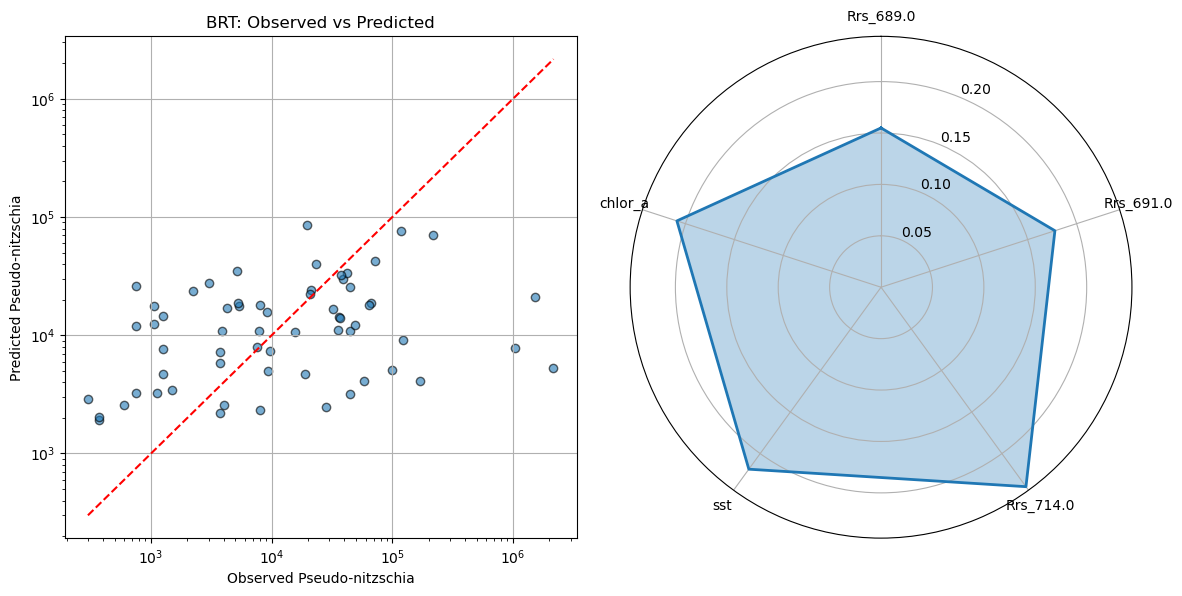

In [75]:
# Prepare data for STAR plot
importances = brt.feature_importances_
importances = importances / importances.sum()
labels = predictors
angles = np.linspace(0, 2 * np.pi, len(importances), endpoint=False)

# Close the loop for polar plot
angles = np.concatenate([angles, angles[:1]])
importances_plot = np.concatenate([importances, importances[:1]])

# Create side-by-side figure
fig = plt.figure(figsize=(12, 6))

# Scatter plot (left)
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(y_test_lin, y_pred_lin, alpha=0.6, edgecolor="k")
ax1.plot([y_test_lin.min(), y_test_lin.max()], [y_test_lin.min(), y_test_lin.max()], "r--")
ax1.set_xlabel("Observed Pseudo-nitzschia")
ax1.set_ylabel("Predicted Pseudo-nitzschia")
ax1.set_title("BRT: Observed vs Predicted")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.grid(True)

# Polar plot (right)
ax2 = fig.add_subplot(1, 2, 2, polar=True)
ax2.plot(angles, importances_plot, linewidth=2)
ax2.fill(angles, importances_plot, alpha=0.3)
ax2.set_theta_direction(-1)
ax2.set_theta_offset(np.pi / 2)
ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(labels)
#ax2.set_title("BRT Feature Importance", pad=25)

plt.tight_layout()
plt.show()



In [13]:
top10 = (
    pd.DataFrame({
        "predictor": predictors,
        "importance": brt.feature_importances_
    })
    .sort_values("importance", ascending=False)
    .head(10)
)

top10



,predictor,importance
173,chlor_a,0.064542
172,sst,0.051267
149,Rrs_689.0,0.048962
150,Rrs_691.0,0.046188
169,Rrs_714.0,0.042760
70,Rrs_520.0,0.028739
171,Rrs_719.0,0.027614
92,Rrs_575.0,0.022397
170,Rrs_717.0,0.019025
147,Rrs_687.0,0.016968


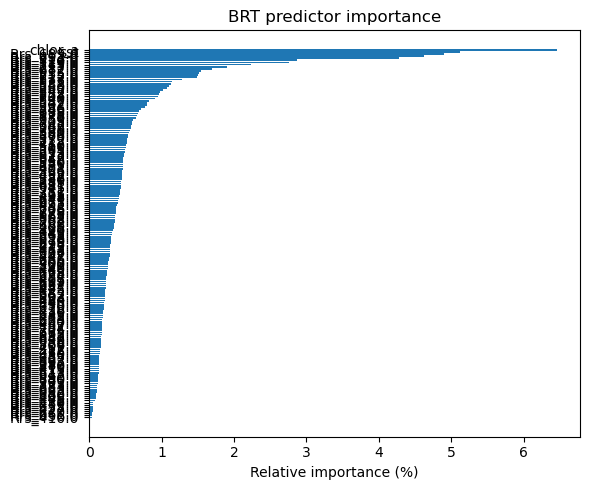

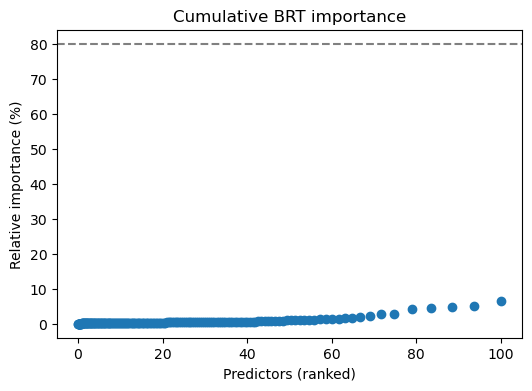

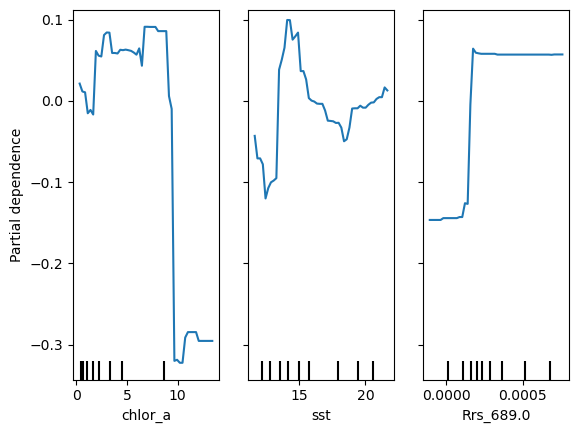

In [14]:
imp = pd.DataFrame({
    "predictor": predictors,
    "importance": brt.feature_importances_
})

# Normalize to %
imp["importance_pct"] = 100 * imp["importance"] / imp["importance"].sum()

# Sort
imp = imp.sort_values("importance_pct", ascending=True)

# Plot
plt.figure(figsize=(6, 5))
plt.barh(imp["predictor"], imp["importance_pct"])
plt.xlabel("Relative importance (%)")
plt.title("BRT predictor importance")
plt.tight_layout()
plt.show()

imp["cumulative"] = imp["importance_pct"].cumsum()

plt.figure(figsize=(6, 4))
plt.plot(imp["cumulative"], imp["importance_pct"], "o")
plt.axhline(80, linestyle="--", color="gray")
plt.ylabel("Relative importance (%)")
plt.xlabel("Predictors (ranked)")
plt.title("Cumulative BRT importance")
plt.show()

from sklearn.inspection import PartialDependenceDisplay

top_vars = imp.sort_values("importance_pct", ascending=False)["predictor"][:3]

PartialDependenceDisplay.from_estimator(
    brt,
    X_train,
    features=top_vars,
    grid_resolution=50
)
plt.show()

In [ ]:
# Residuals

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

residuals = y_train - y_pred

def residual_plot(df_map):
    fig, ax = plt.subplots(
        figsize=(7,5),
        subplot_kw={"projection": ccrs.PlateCarree()}
    )
    # symmetric limits around 0
    res = df_map["residual"].values
    max_abs = np.nanmax(np.abs(res))
    vmin, vmax = -max_abs, max_abs

    ax.coastlines(resolution="110m")
    ax.add_feature(cfeature.LAND, facecolor="0.9")

    sc = ax.scatter(
        df_map["lon"],
        df_map["lat"],
        c=df_map["residual"],
        cmap="coolwarm",
        s=6,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree()
    )

    plt.colorbar(sc, ax=ax, label="Residual (y - y_pred)")
    bias = df_map["residual"].mean()
    plt.title(f"Residual Map (mean bias = {bias:.3f})")
    plt.show()